# **Assignment 2: Implementing a Graph Convolutional Network**

### alt title: batching sucks

## **Dataset & Setup**

"Download and pre-process the (smaller) citation benchmark baselines Cora, Citeseer and PubMed (As with Nations last time). We will be performing node classification on these baselines."

We pull in the Cora, Citeseer, PubMed datasets via the `torch_geometric` package--reference paper for the datasets: [Revisiting Semi-Supervised Learning with Graph Embeddings](https://arxiv.org/pdf/1603.08861.pdf)

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu115.html

In [ ]:
import torch
import torch_geometric as tg
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
from scipy.linalg import sqrtm

import seaborn as sns
import matplotlib.pyplot as plt

import math
import random
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
user = input('Who is using this notebook? ').lower()
if user == 'clare':
    data_dir = '/content/drive/MyDrive/Undergrad/College Year 3/Oxford/Graph Machine Learning/data'
elif user == 'emilio':
    data_dir = '/content/drive/MyDrive/Graph ML/data'
else:
    raise NotImplementedError('Please add your name and specify the file path to the data directory')
dataset_name = 'Cora' # 'Cora', 'CiteSeer', 'PubMed'
data_split = 'public'
dataset = tg.datasets.Planetoid(root = data_dir, name = dataset_name, split = data_split)

Who is using this notebook? clare


In [ ]:
# Choosing the device to train on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

Using cpu


In [ ]:
print(dataset.data.num_edges)

10556


In [ ]:
# Get overview of the data object and then extract features
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
# Pull out dataset attributes 
graph = dataset[0] # Index 0 because only once graph in Cora dataset
X = graph.x # Node feature matrix (number of nodes x number of features)
edge_index = graph.edge_index # Compact version of adjacency matrix in COO format (2 x number of edges)
y = graph.y # Target class for each node (1 x number of nodes)

train_mask = graph.train_mask
valid_mask = graph.val_mask
test_mask = graph.test_mask

x_train = X[train_mask] # 140 data points
x_valid = X[valid_mask] # 500 data points
x_test = X[test_mask] # 1000 data points

y_train = y[train_mask]
y_valid = y[valid_mask]
y_test = y[test_mask]

num_classes = dataset.num_classes
num_features = dataset.num_node_features
num_nodes = graph.num_nodes
all_nodes = [i for i in range(num_nodes)]
graph.is_undirected()

True

In [ ]:
# Callback to perform early stopping
#   - if current val mean rank isn't better than any of last "how_many_to_check" epochs, stop the training
def early_stopping_callback(model_type, model, X, all_nodes, val_mask, acc_array, how_many_to_check):
    """ Early stopping on validation dataset

    :param model_type: string to specify model type as MLP or GCN
    :param model: current GCN model to evaluate
    :param X: Features for all nodes in graph [num_nodes x num_features]
    :param all_nodes: list of all node IDs
    :param val_mask: nodes to filter on for validation set
    :param acc_array: array of previous accuracies computed on validation dataset
    :param how_many_to_check: how far back in accuracy array to look for validation comparison

    :return: True if we should stop and False otherwise
    """

    # Evaluate GCN using validation dataset
    with torch.no_grad():
        # Extracting model predictions
        if model_type.lower() == 'mlp':
            val_logits = model(X[sorted(val_mask)])
        elif model_type.lower() == 'gcn':
            val_logits = model(X, set(val_mask), all_nodes)
        else:
            raise NotImplementedError(model_type, 'has not been implemented as a model type. Try: gcn or mlp')

        pred_probs = F.softmax(input = val_logits, dim = 1)
        y_pred = torch.argmax(pred_probs, dim = 1)

        # Evaluating accuracy
        accuracy = np.mean((y_pred == y[sorted(val_mask)]).cpu().numpy())
      
    acc_array.append(accuracy)
    if len(acc_array) > how_many_to_check + 1:
        recent_acc = np.array(acc_array[-(how_many_to_check+1) : -1])

        if np.count_nonzero(recent_acc < accuracy) > 0:
            return False
        print(f'Final validation accuracy: {round(accuracy * 100)}%')
        return True

    return False

## **MLP for Comparison**

"To get a point of comparison, please implement a simple multi-layer perceptron (MLP) (the choice of hyper-parameters isn’t crucial, so don’t tune this too much), and train this model on node features to perform classification."

We can implement the MLP using normal `torch`.

In [ ]:
# Define our MLP as a class and include how our forward pass should work with layers
# This is a typical ANN w/one hidden layer
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(num_features, 500) # fc stands for fully connected
        self.fc2 = nn.Linear(500, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Produces our logits
        
        return x

In [ ]:
def train_mlp(learning_rate, epochs, batch_size, how_many_to_check, model, optimizer, loss_func, x_train, y_train):
    # Establish the training loop
    acc_array = []
    for e in range(epochs):
        for b in range(int(x_train.shape[0] / batch_size)):
            # Sample a batch
            perm = torch.randperm(x_train.shape[0]) # Could simplify and use shuffle here
            idx = perm[:batch_size]
            x_train_batch = x_train[idx]
            y_train_batch = y_train[idx]

            optimizer.zero_grad()
            logits = model(x_train_batch)
            loss = loss_func(logits, y_train_batch)
            loss.backward()
            optimizer.step()

        # if((e + 1) % 10 == 0):
        #     print('Finished epoch', e + 1)
        
        # Validation does not help implementation so ignore
        # if valid_mask is not None:
        #     if early_stopping_callback('mlp', model, X, all_nodes, valid_mask, acc_array, how_many_to_check):
        #         print('Stopping at epoch:', e+1)
        #         break

In [ ]:
# Evaluate MLP using test dataset
def eval_mlp(model, x_test, y_test):
    with torch.no_grad():
        test_logits = model(x_test)
        pred_probs = F.softmax(input = test_logits, dim = 1)
        y_pred = torch.argmax(pred_probs, dim = 1)
        accuracy = np.mean((y_pred == y_test).numpy())
        print(f'Accuracy was: {round(accuracy*100, 2)}%')

        return accuracy

In [ ]:
# MLP training loop hyperparameters
learning_rate = 0.001
epochs = 400
batch_size = 32
how_many_to_check = 10

In [ ]:
test_accs = []
for i in range(10):
    # Instantiate a new instance of our Net class
    model = Net(num_features, num_classes)
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9) 
    loss_func = nn.CrossEntropyLoss()
    train_mlp(learning_rate, epochs, batch_size, how_many_to_check, model, optimizer, loss_func, x_train, y_train)
    test_accs.append(eval_mlp(model, x_test, y_test))

print(f'Average test accuracy for MLP was {round(np.mean(test_accs)*100, 2)}%')

Accuracy was: 58.8%
Accuracy was: 58.3%
Accuracy was: 59.9%
Accuracy was: 59.2%
Accuracy was: 60.3%
Accuracy was: 59.3%
Accuracy was: 59.7%
Accuracy was: 59.5%
Accuracy was: 59.5%
Accuracy was: 59.2%
Average test accuracy for MLP was 59.37%


## **GCN Implementation**

Based on the equations in Lectures 3 and 4, select a GNN model of your choice (GCN, GraphSAGE, GGNN, GIN, GAT) (the one you’d enjoy building the most) and implement it from scratch. In doing so, I expect you to stumble upon some computational hurdles (which is completely fine and normal).

---

**Batching notes:**

- [Locality-Based Mini Batching for Graph Neural Networks](https://openreview.net/pdf?id=W5PbuwQFzZx): has a good review of batching procedures for GNNs
- [Inductive Representation Learning on Large Graphs](https://papers.nips.cc/paper/2017/hash/5dd9db5e033da9c6fb5ba83c7a7ebea9-Abstract.html): using batching algorithm described in "Appendix A Minibatch pseudocode"

**Definitions:**
- $\hat{A}$: `[num_nodes x num_nodes]`
- $H^{(t-1)}$: `[num_nodes x in_features]`
- $W^{(t)}$: `[in_features x out_features]`

**Network Setup:**

Let $Z$ be the logits outputted by the model. We implemented our GCN with one hidden layer, with $W^{(0)}$ `[in_features x 100]` and $W^{(1)}$ `[100 x num_classes]`.

$$Z = \hat{A} \cdot \text{ReLU}(\hat{A} \cdot X \cdot W^{(0)}) \cdot W^{(1)}$$

In [ ]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        """ Custom GCN layer to facilitate message passing in our graph 
        
        :param in_features: scalar number of layer input features
        :param out_features: scalar number of layer output features
        """

        super().__init__()
        weights = torch.Tensor(in_features, out_features)
        self.weights = nn.Parameter(weights)  # nn.Parameter is a tensor that's a module parameter
        self.in_features = in_features
        self.out_features = out_features

        # Initialize weights
        nn.init.xavier_normal_(self.weights)
    
    def forward(self, H_t_1, A_hat):
        """ Matrix multiply A_hat x H_t_1 x the weights matrix

        :param H_t_1: Previous iteration's stacked embedded vectors
        :param A_hat: Masked version of augmented adjacency matrix 

        :return: A_hat x H_t_1 x weights
        """
        
        return torch.matmul(torch.matmul(A_hat, H_t_1), self.weights)

In [ ]:
class GCN(nn.Module):
    def __init__(self, num_features, num_classes, A, neighbor_dict, device, K = 2):
        """ Multi-layer Graph Convolutional Neural Network implemented with message-passing structure 
        
        :num_features: Number of training features for each node
        :num_classes: Number of output classes
        :param A: Adjacency matrix as numpy array
        :param neighbor_dict: Dictionary to retrieve node neighbors (values are sets)
        :param device: Runtime device
        :param K: Integer number of hops to pass messages
        """

        super().__init__()
        self.A = A
        self.neighbor_dict = neighbor_dict
        self.K = K
        self.feature_reps = {}
        self.device = device

        # Build K graph convolution layers
        self.build_K_layers(num_features, num_classes)

    def build_K_layers(self, num_features, num_classes):
        """ Build the K sequential GraphConvolution layers and store in class value gc_layers

        :param num_features: input size to first GC layer
        :param num_classes: output size of final GC layer
        """

        gc_layers = {}
        
        for i in range(1, self.K + 1):
            if self.K == 1:
                in_features = num_features
                out_features = num_classes
            elif i == 1:
                in_features = num_features
                out_features = 16
            elif i == self.K:
                in_features = 16
                out_features = num_classes
            else:
                in_features = 16
                out_features = 16
            gc_layers[f'gc{i}'] = GraphConvolution(in_features, out_features)

        self.gc_layers = nn.ModuleDict(gc_layers)
    
    def get_batch_data(self, B, X):
        """ Compute A_hat_0, ..., A_hat_k using a message passing batching structure 
        
        :param B: set of nodes randomly sampled for our current batch
        :param X: feature vectors for all nodes in the training set

        :return: list of B's indexed by k, list of A_hats indexed by k
        """
        
        list_B = [None for i in range(self.K + 1)]
        list_A_hat = [None for i in range(self.K + 1)]

        list_B[self.K] = B
        for k in range(self.K, 0, -1):
            # Get the set B_k-1
            list_B[k - 1] = list_B[k]
            for u in list_B[k]:
                list_B[k - 1] = list_B[k - 1].union(self.neighbor_dict[u])

        list_B = [sorted(list(b)) for b in list_B] # going from sets to sorted lists

        for k in range(0, self.K+1):
            # Get A_sub using a mask of the current B
            B_mask = list_B[k]
            A_sub = self.A[B_mask][:, B_mask].cpu()

            # Compute the diagonalized degree matrix D
            degrees = torch.sum(A_sub, axis=1)
            D = torch.from_numpy(np.diag(degrees, k = 0))

            # Compute A_hat for the current B
            I = np.eye(A_sub.shape[0])
            temp = np.linalg.matrix_power((D.numpy() + I), -1)
            temp2 = sqrtm(temp)
            A_hat = torch.from_numpy(np.matmul(np.matmul(temp2, (I + A_sub.numpy())), temp2)).float()
            A_hat = A_hat.to(self.device)
            list_A_hat[k] = A_hat

        return list_B, list_A_hat

    def build_H(self, B_k_1, B_k, H_k):
        """
        Sample and stack the required feature vectors for the next GraphConvolution

        :param B_k_1: Previous batch node IDs
        :param B_k: Current batch node IDs
        :param H_k: Full feature vecor corresponding to nodes in B_k-1

        :return: Newly stacked H
        """

        H_k = H_k.cpu()

        for i, node in enumerate(B_k_1):
            self.feature_reps[node] = H_k[i]
        
        H = []
        for node in B_k:
            H.append(self.feature_reps[node])

        H = torch.reshape(torch.cat(H, dim = 0), (-1, H_k.shape[1]))
        H = H.to(self.device)

        return H

    def forward(self, X, B, all_nodes):
        """ Define the forward pass through the complete GCN

        :param X: All nodes and their features [num_nodes in graph x num_features]
        :param B: Set of nodes IDs for current batch
        :param all_nodes: Node IDs for all nodes

        :return: Logits for nodes specified by B
        """

        # Clear the feature representations
        self.feature_reps = {} 
        
        # Compute the message passing batch prerequisites 
        list_B, list_A_hat = self.get_batch_data(B, X)

        H = self.build_H(all_nodes, list_B[0], X) # H_0 has feature vectors w/length num_features
        for i in range(1, self.K+1):
            H = self.gc_layers[f'gc{i}'](H, list_A_hat[i-1])
            if i < self.K:
                H = F.relu(H)
            H = self.build_H(list_B[i-1], list_B[i], H)

        return H

### **Baby test data set**

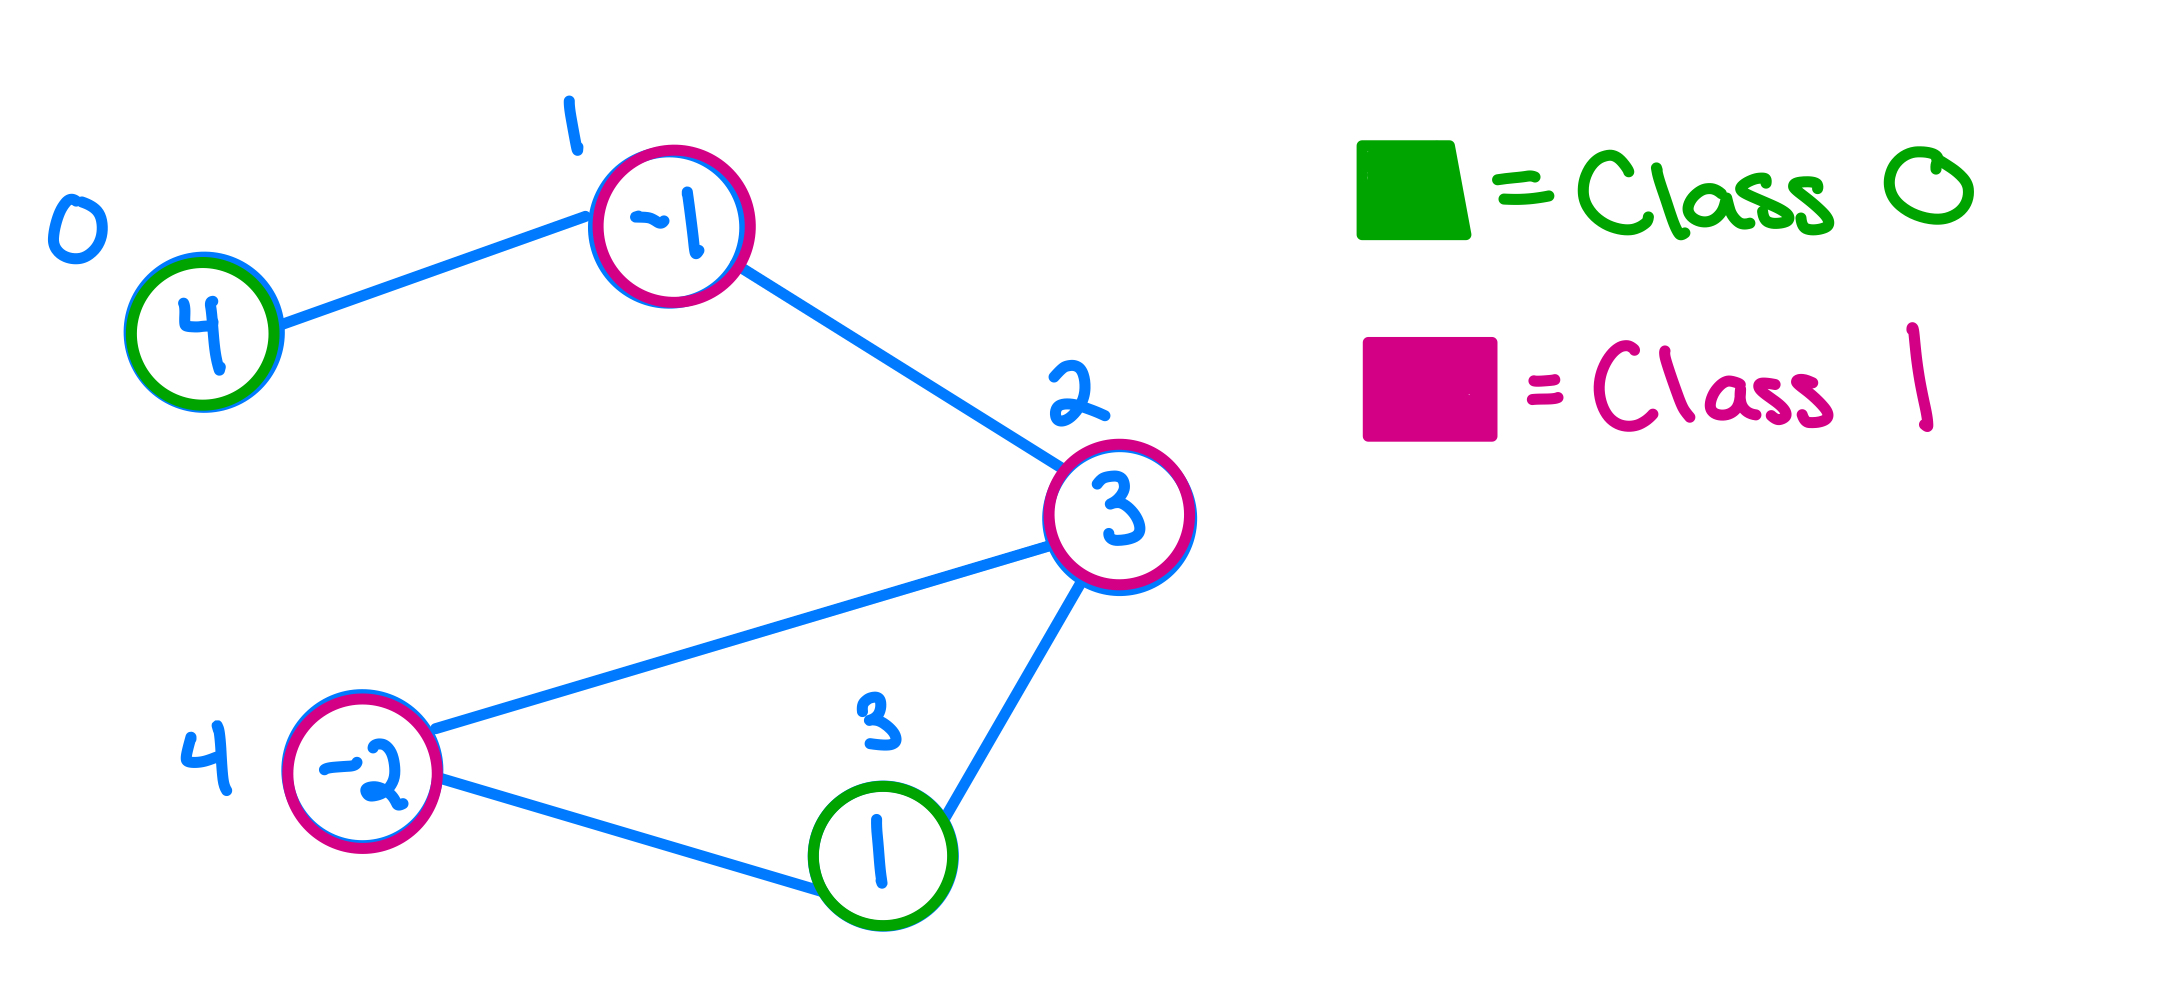

In [ ]:
# Baby dataset to test with
edge_index = torch.tensor([[0, 1, 1, 2, 2, 2, 3, 4, 4, 3],
                           [1, 0, 2, 1, 4, 3, 2, 2, 3, 4]], dtype=torch.long)
x = torch.tensor([[4], [-1], [3], [1], [-2]], dtype=torch.float).to(device)
y = torch.tensor([0, 1, 1, 0, 1]).to(device)

train_mask = [1, 2, 3, 4]
test_mask = [0]

data = tg.data.Data(x = x, edge_index = edge_index, y = y)

num_nodes = data.num_nodes
all_nodes = [i for i in range(num_nodes)]
print('All nodes:', all_nodes)
num_classes = 2
num_features = 1 # Length of each row in x
data.is_undirected()

All nodes: [0, 1, 2, 3, 4]


True

In [ ]:
# Back the adjacency matrix out of COO format and get a dictionary of neighbors
neighbor_dict = {}
for i in range(num_nodes):
    neighbor_dict[i] = set()

edge_index_T = edge_index.numpy().transpose()
A = np.zeros(shape=(num_nodes, num_nodes))
for edge in edge_index_T:
    A[edge[0]][edge[1]] = 1
    neighbor_dict[edge[0]].add(edge[1])
    neighbor_dict[edge[1]].add(edge[0])
A = torch.from_numpy(A)
A.to(device)

tensor([[0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [0., 1., 0., 1., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 1., 1., 0.]], dtype=torch.float64)

In [ ]:
print(neighbor_dict)

{0: {1}, 1: {0, 2}, 2: {1, 3, 4}, 3: {2, 4}, 4: {2, 3}}


In [ ]:
# Compute D from A by summing each row and placing at the target index
sum = torch.sum(A, axis=1)
D = torch.from_numpy(np.diag(sum, k = 0))
D

tensor([[1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0.],
        [0., 0., 3., 0., 0.],
        [0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 2.]], dtype=torch.float64)

In [ ]:
# Compute Laplacian
L = D - A
L

tensor([[ 1., -1.,  0.,  0.,  0.],
        [-1.,  2., -1.,  0.,  0.],
        [ 0., -1.,  3., -1., -1.],
        [ 0.,  0., -1.,  2., -1.],
        [ 0.,  0., -1., -1.,  2.]], dtype=torch.float64)

In [ ]:
# Raise L to some power
np.linalg.matrix_power(L, 10)

array([[  31542.,  -97667.,  177357.,  -55616.,  -55616.],
       [ -97667.,  306566., -563613.,  177357.,  177357.],
       [ 177357., -563613., 1047536., -330640., -330640.],
       [ -55616.,  177357., -330640.,  133974.,   74925.],
       [ -55616.,  177357., -330640.,   74925.,  133974.]])

In [ ]:
# Compute A hat which is useful for the class slide implementation of GCNs
I = np.eye(num_nodes)
temp = np.linalg.matrix_power((D.numpy() + I), -1)
temp2 = sqrtm(temp)
A_hat = torch.from_numpy(np.matmul(np.matmul(temp2, (I + A.numpy())), temp2)).float()
A_hat

tensor([[0.5000, 0.4082, 0.0000, 0.0000, 0.0000],
        [0.4082, 0.3333, 0.2887, 0.0000, 0.0000],
        [0.0000, 0.2887, 0.2500, 0.2887, 0.2887],
        [0.0000, 0.0000, 0.2887, 0.3333, 0.3333],
        [0.0000, 0.0000, 0.2887, 0.3333, 0.3333]])

In [ ]:
# Model hyperparameters
learning_rate = 0.001
epochs = 1
batch_size = 3

In [ ]:
# Define model, instantiate optimizer, define loss function
model = GCN(num_features, num_classes, A, neighbor_dict, device, K = 2).to(device)
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9) 
loss_func = nn.CrossEntropyLoss()

In [ ]:
sd = copy.deepcopy(model.state_dict())

In [ ]:
# Training loop for GCN on baby dataset
for e in range(epochs):
    for b in range(int(len(train_mask) / batch_size)):
        # Sample a batch of primary nodes from train_mask.
        # This ensures we only update node representations for those that 
        # we have targets for during train time.
        B = random.sample(train_mask, batch_size)

        # Zero out the gradient before new training with batch
        optimizer.zero_grad()

        # Obtain secondary, tertiary, etc. nodes for batch and forward pass
        logits = model(x, set(B), all_nodes)

        # Compute loss
        loss = loss_func(logits, y[B])
        # loss.requires_grad = True # Cry about pytorch

        # Back propogation
        loss.backward()
        optimizer.step()

    print('Finished epoch', e)

Finished epoch 0


In [ ]:
# Checking that model parameters actually updated during training
# TODO: verify that the same thing is happening when we run on Cora - easy check is that pre- and post-training accuracy on test set should be identical!
for key in model.state_dict():
  print(f'{(~(model.state_dict()[key] == sd[key])).sum()} parameters of the model changed during training')

6 parameters of the model changed during training
12 parameters of the model changed during training


In [ ]:
# Evaluate GCN using test dataset
with torch.no_grad():
    test_logits = model(x, set(test_mask), all_nodes)
    pred_probs = F.softmax(input = test_logits, dim = 1)
    y_pred = torch.argmax(pred_probs, dim = 1)
    accuracy = np.mean((y_pred == y[test_mask]).cpu().numpy())
    print(f'Accuracy was: {accuracy*100}%')

Accuracy was: 100.0%


### **GCN with the full dataset**
- [Semi-Supervised Classification with
Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf%EF%BC%89): the paper that introduces GCN and uses the same MPNN framework as we have implemented... has benchmark accuracies for Cora, Citeseer, and PubMed
  - They don't use minibatching :(

---

**Things we've tried for improving accuracy:**
1. Aligned our setup with the original GCN paper in terms of network architecture (where ReLUs go, weight initialization, learning rate, Adam instead of SGD)
2. Increased the length of the hidden vector embeddings (these were 2, now they're 100) to make the model more flexible... slightly different from paper, but seems like it can't hurt too much!
3. Added the ability to train the model on GPU
4. Increased the batch size


In [ ]:
# Pull out dataset attributes 
graph = dataset[0] # Index 0 because each dataset is only one graph
X = graph.x.to(device) # Node feature matrix (number of nodes x number of features) - for ALL nodes, not just training!
edge_index = graph.edge_index # Compact version of adjacency matrix in COO format (2 x number of edges)
y = graph.y.to(device) # Target class for each node (1 x number of nodes)

train_mask = [int(n) for n in list(torch.nonzero(graph.train_mask).reshape(-1))]
valid_mask = [int(n) for n in list(torch.nonzero(graph.val_mask).reshape(-1))]
test_mask = [int(n) for n in list(torch.nonzero(graph.test_mask).reshape(-1))]

print(f'There are {edge_index.shape[1]} edges in total')

num_classes = dataset.num_classes
num_features = dataset.num_node_features
num_nodes = graph.num_nodes
all_nodes = [i for i in range(num_nodes)] # Assume node IDs go from 0 to num_nodes - 1

There are 10556 edges in total


In [ ]:
# Back the adjacency matrix out of COO format and get a dictionary of neighbors
neighbor_dict = {}
for i in range(num_nodes):
    neighbor_dict[i] = set()

edge_index_T = edge_index.numpy().transpose()
A = np.zeros(shape = (num_nodes, num_nodes))
for edge in edge_index_T:
    A[edge[0]][edge[1]] = 1
    neighbor_dict[edge[0]].add(edge[1])
    neighbor_dict[edge[1]].add(edge[0])
A = torch.from_numpy(A).to(device)
print(f'Adjacency matrix of size {tuple(A.shape)} with {int(A.sum())} edges')

Adjacency matrix of size (2708, 2708) with 10556 edges


In [ ]:
# Training hyperparameters - obtained from GCN paper!
learning_rate = 0.01
epochs = 100
batch_size = 32
how_many_to_check = 10
K = 2 # Specify the number of GCN layers (we found 2 performed best)

# Define model, instantiate optimizer, define loss function
model = GCN(num_features, num_classes, A, neighbor_dict, device, K = K).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
loss_func = nn.CrossEntropyLoss()

In [ ]:
# Training loop for GCN
acc_array = []
for e in range(epochs):
    for b in range(int(len(train_mask) / batch_size)):
        # Sample a batch of primary nodes from train_mask.
        # This ensures we only update node representations for those that 
        # we have targets for during train time.
        B = sorted(random.sample(train_mask, batch_size)) # needs to be in the same order as logits will be - sorted by index!

        # Zero out the gradient before new training with batch
        optimizer.zero_grad()

        # Obtain secondary, tertiary, etc. nodes for batch and forward pass
        logits = model(X, set(B), all_nodes)

        # Compute loss
        loss = loss_func(logits, y[B])

        # Back propogation
        loss.backward()
        optimizer.step()

    if (e + 1) % 5 == 0:
      print('Finished epoch', e + 1)
    
    if valid_mask is not None:
        if early_stopping_callback('gcn', model, X, all_nodes, valid_mask, acc_array, how_many_to_check):
            print('Stopping at epoch:', e + 1)
            break

Finished epoch 5
Finished epoch 10
Finished epoch 15
Finished epoch 20
Finished epoch 25
Final validation accuracy: 76%
Stopping at epoch: 28


In [ ]:
# Evaluate GCN using test dataset
tot_correct = 0
for i in range(0, len(test_mask), 32):
    # We batch the test dataset to prevent an out of memory error
    B = test_mask[i : i + 32]
    with torch.no_grad():
        # Extracting model predictions
        test_logits = model(X, set(B), all_nodes)
        pred_probs = F.softmax(input = test_logits, dim = 1)
        y_pred = torch.argmax(pred_probs, dim = 1)

        # Evaluating accuracy
        num_correct = np.sum((y_pred == y[sorted(B)]).cpu().numpy())
        tot_correct += num_correct

print(f'Accuracy was: {round(tot_correct / len(test_mask) * 100)}%')

Accuracy was: 78%


### **Analysis & Responses to Questions**

1. **How do GNNs affect performance on node classification relative to MLPs? Do they improve or harm performance? Why?**
  - Using a GCN substantially improves classification accuracy on these datasets. This implies that the information inherent in the relational structure of the data is important for determining the classes of nodes in the graph.
  - Since the formulation of a GCN leverages the relational structure, it substantially improves on the MLP, which considers nodes indepently.

| Model                     | Cora        | Citeseer    | Pubmed      |
| :-                        | :-:         | :-:         | :-:         |
| MLP                       | 53%         | 59%         | 43%         |
| **GCN (ours)**            | **80%**     | **64%**     | **73%**     |
| GCN (Kipf & Welling, 2017)| 82%         | 70%         | 79%         | 

2. **Please study how GNN labels are computed relative to the neighbours of a given node. That is, for a node with a target class, consider the classes and features of neighbours around it (i.e., a case study),and see how correlated/important neighbour features/classes are with the target node’s final class prediction.**
  - We computed accuracy once for models of 0 to 4 convolution layers. We only tested on teh Cora dataset, because it runs the fastest and the GCN paper also used Cora to train hyperparameters like the number of layers `K`.
  - In the next code block we plot accuracy against the number of convolution layers in the GCN. This corresponds to the degree of node separations considered during training due to the MPNN structure--this is codified by the batching algorithm in the training loop. For example, if `K=2` we create two convolution layers. Given a batch `B`, we consider all neighbors and neihbors of neihbors of `B` to build the embeddings/logits for nodes in `B`. By increasing the number of layers we see that a degree of 2 performs the best, i.e., considering 3 steps from `B` does not contribute to representational power.   
  - Theoretically, we think that as you go farther out the representations of the nodes become more homogenous, so embeddings are less discrimininting--effective receptive field is too large. For `K=0`, we used the output of the MLP, because classification only considers a node's own features. This is not a perfect comparison because MLP has a slightly different model structure.

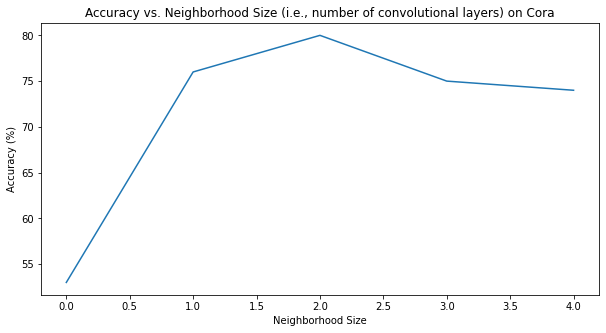

In [ ]:
# Logging performance with different numbers of layers
perf_data = pd.DataFrame(np.array([[0, 53], [1, 76], [2, 80], [3, 75], [4, 74]]), columns = ['neighborhood_size', 'accuracy'])

plt.figure(figsize = (10, 5))
sns.lineplot(data = perf_data, x = 'neighborhood_size', y = 'accuracy')
plt.xlabel('Neighborhood Size')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Neighborhood Size (i.e., number of convolutional layers) on Cora');

### **Future Considerations**

1. Use a more sophisticated batching algorithm e.g. instead of random sampling deduce the most salient nodes with clustering and then batch on them as is proposed [here](https://openreview.net/pdf?id=W5PbuwQFzZx).
2. Cache all static batching parameters (e.g. $\hat{A}$ and $B^0, ..., B^K$) for the validation set early stopping callback. Since this is not vectorized, GPUs do not speed up computation time.